In [1]:
# importing relevant packages

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof

In [2]:
# loading in the datasets 
msl_ds = xr.open_dataset("msl_monthly.nc")
sst_ds = xr.open_dataset("sst_monthly.nc")
v10_ds = xr.open_dataset("v10_monthly.nc")
u10_ds = xr.open_dataset("u10_monthly.nc")

In [3]:
# turning datasets into numpy arrays - easier for manipulating 
msl = msl_ds.msl.to_numpy()
sst = sst_ds.sst.to_numpy()
v10 = v10_ds.v10.to_numpy()
u10 = u10_ds.u10.to_numpy()

In [87]:
# variables holding dimensions, coordinates and times of each dataset
msl_dims = msl_ds.dims
msl_coords = msl_ds.coords
msl_times = msl_ds.time

sst_dims = sst_ds.dims
sst_coords = sst_ds.coords
sst_times = sst_ds.time

v10_dims = v10_ds.dims
v10_coords = v10_ds.coords
v10_times = v10_ds.time

u10_dims = u10_ds.dims
u10_coords = u10_ds.coords
u10_times = u10_ds.time

### For looking at the region 30°S-30°N and 100°E-70°W, we need to index the latitude and longitude data

- 480 longitude data points evenly spaced between 0 and 360 degrees
- 241 latitude data points evenly spaced between -90 and 90 degrees


In [ ]:
# Subset the NS-EW region 
subset_msl_data = msl_ds.sel(latitude=slice(30, -30), longitude=slice(100, 290))
subset_msl_data

<xarray.Dataset>
Dimensions:    (longitude: 253, time: 459, latitude: 81)
Coordinates:
  * longitude  (longitude) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01
  * latitude   (latitude) float32 30.0 29.25 28.5 27.75 ... -28.5 -29.25 -30.0
Data variables:
    msl        (time, latitude, longitude) float32 1.015e+05 ... 1.015e+05

In [ ]:
# function to create bi-monthly seasons
# INPUT: data = xarray dataset
# OUTPUT: rolling mean values for adjacent timesteps
# from chatGPT: 
# for   Time steps:  [t1, t2, t3, t4]
#       Rolling mean: [(t1+t2)/2, (t2+t3)/2, (t3+t4)/2]
def create_bimonthly_seasons(data):
    return data.rolling(time=2, center=True).mean().dropna(dim='time')

bimonthly_msl_data = create_bimonthly_seasons(subset_msl_data)

In [27]:
# Step 1: Select the specific variable (assuming 'your_variable_name' is the name of your variable)
data_variable = bimonthly_msl_data['msl']  # Replace with your variable name

# Step 2: Stack spatial dimensions (lat, lon) into a single 'space' dimension
data_reshaped = data_variable.stack(space=('latitude', 'longitude')).transpose('time', 'space')

# Step 3: Handle missing or invalid values (if any)
data_masked = np.ma.masked_invalid(data_reshaped.values)

# Step 4: Perform EOF analysis
from eofs.standard import Eof
solver = Eof(data_masked)

# Step 5: Extract the first EOF (spatial pattern) and its time series (principal component)
eof1 = solver.eofs(neofs=1)  # First EOF (spatial pattern)
pc1 = solver.pcs(npcs=1)    # Principal Component (time series)

In [28]:
# Explained variance for the first EOF
variance_explained = solver.varianceFraction(neigs=1)

# Print variance explained
print(f"Variance explained by EOF1: {variance_explained[0] * 100:.2f}%")

Variance explained by EOF1: 68.83%


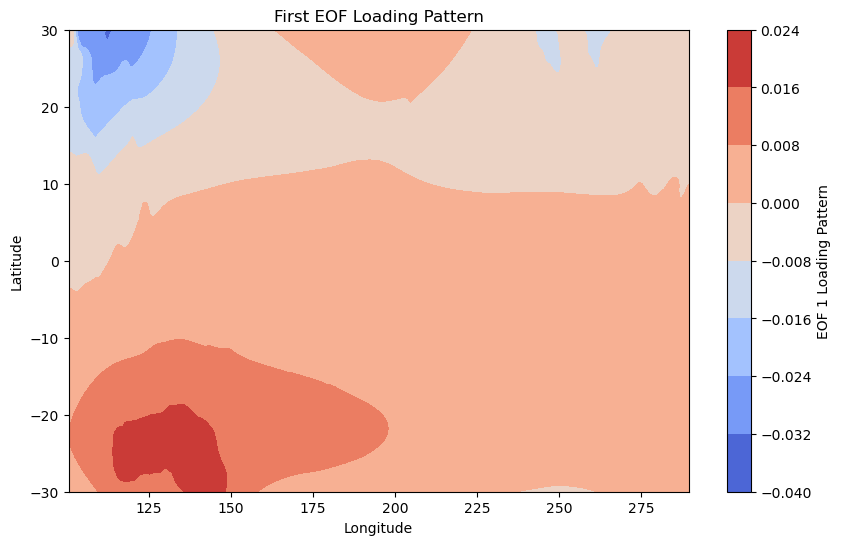

In [32]:
# Reshape EOF1 back to spatial dimensions for plotting
eof1_spatial = eof1[0].reshape((len(subset_msl_data['latitude']), len(subset_msl_data['longitude'])))

plt.figure(figsize=(10, 6))
plt.contourf(subset_msl_data['longitude'], subset_msl_data['latitude'], eof1_spatial, cmap='coolwarm')
plt.colorbar(label='EOF 1 Loading Pattern')
plt.title('First EOF Loading Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

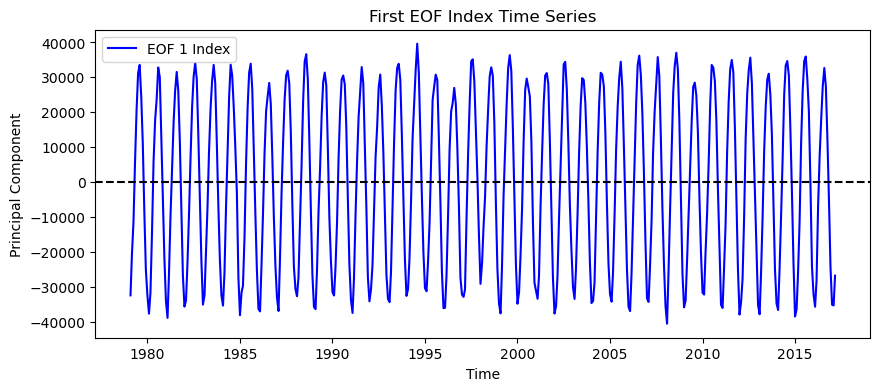

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(bimonthly_msl_data['time'], pc1[:, 0], label='EOF 1 Index', color='b')
plt.axhline(0, color='k', linestyle='--')
plt.title('First EOF Index Time Series')
plt.xlabel('Time')
plt.ylabel('Principal Component')
plt.legend()
plt.show()